Importação de Bibliotecas Necessárias


In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Carregamento do Dataset


In [2]:
data = pd.read_csv('base_amostra.csv')  

Definição da Variável Alvo e das Features

In [3]:
target = "[Q088] Algum médico já lhe deu o diagnóstico de DORT? "
X = data.drop(columns=[target])
y = data[target]

Identificação de Colunas Numéricas e Categóricas

In [4]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

Configuração do Modelo e do Pipeline

In [5]:
# Solver: SGD; Função de ativação: logistic; Máximo de iterações: 1000
mlp = MLPClassifier(solver='sgd',
                     activation='logistic', 
                     max_iter=1000, 
                     random_state=42, 
                     alpha=0.001) # Evita overfitting

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('clf', mlp)])

param_grid = {
    'clf__hidden_layer_sizes': [(5,), (10,), (20,)],         # Número de neurônios
    'clf__learning_rate_init': [0.05, 0.1, 0.2]                 # Taxa de aprendizado
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

Divisão dos Dados em Treino e Teste

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

Execução do Grid Search

In [7]:
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', return_train_score=True)
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

# Simplesmente extrai os dados relevantes para visualização
results['neurônios'] = results['param_clf__hidden_layer_sizes'].apply(lambda x: x[0])
results['taxa_aprendizado'] = results['param_clf__learning_rate_init']

# Pivot para heatmap (linhas: neurônios, colunas: taxa de aprendizado)
pivot_table = results.pivot_table(
    values='mean_test_score',
    index='neurônios',
    columns='taxa_aprendizado'
)

Visualização dos Resultados do Grid Search

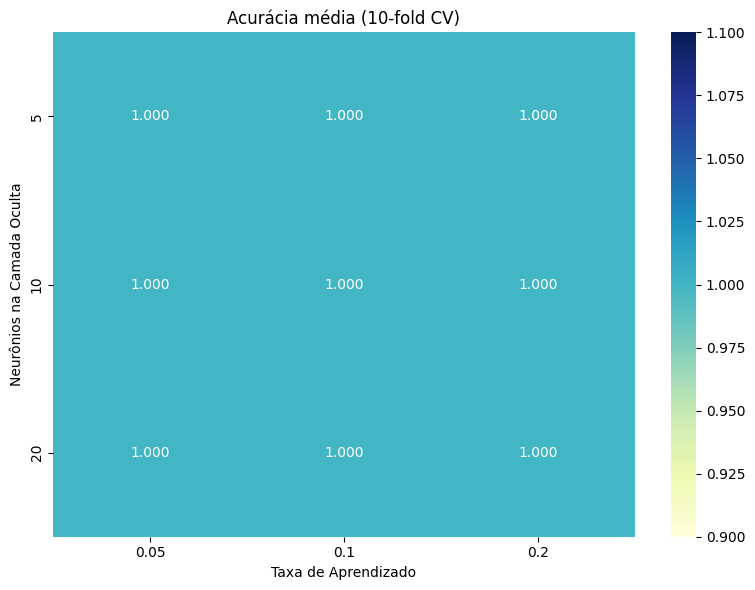

In [8]:
# Gráfico 1: Heatmap de acurácia
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("Acurácia média (10-fold CV)")
plt.xlabel("Taxa de Aprendizado")
plt.ylabel("Neurônios na Camada Oculta")
plt.tight_layout()
plt.show()

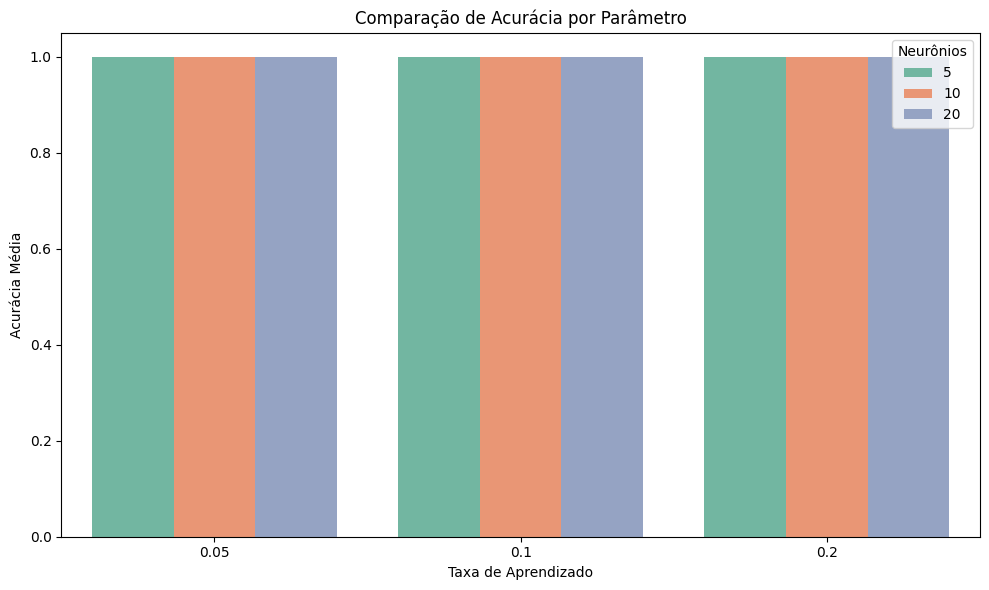

In [9]:
# Gráfico 2: Barras de desempenho de todas as combinações
plt.figure(figsize=(10, 6))
sns.barplot(
    x='taxa_aprendizado',
    y='mean_test_score',
    hue='neurônios',
    data=results,
    palette="Set2"
)
plt.title("Comparação de Acurácia por Parâmetro")
plt.xlabel("Taxa de Aprendizado")
plt.ylabel("Acurácia Média")
plt.legend(title="Neurônios")
plt.tight_layout()
plt.show()

In [10]:
# Também imprime o melhor resultado
print("Melhor Parâmetro:", grid_search.best_params_)
print("Melhor Score (Acurácia Média):", grid_search.best_score_)

Melhor Parâmetro: {'clf__hidden_layer_sizes': (5,), 'clf__learning_rate_init': 0.05}
Melhor Score (Acurácia Média): 1.0


Avaliação no Conjunto de Teste


Relatório de Classificação nos Dados de Teste:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



c:\Users\joaof\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


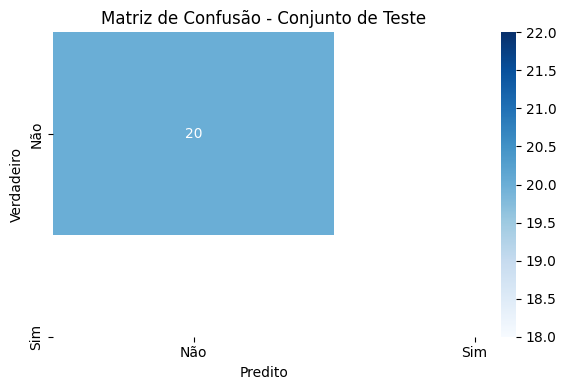

In [11]:
# Usa o melhor modelo encontrado para prever os dados de teste
y_pred = grid_search.best_estimator_.predict(X_test)

# Relatório de classificação
print("\nRelatório de Classificação nos Dados de Teste:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plot da matriz de confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - Conjunto de Teste')
plt.tight_layout()
plt.show()
